## Effect of fc'-embodied carbon relationship on structural components' embodied carbon

Activate and check packages

In [71]:
using Pkg
Pkg.activate("..");
Pkg.status()
Pkg.instantiate()

  Activating project at `e:\dev\ConcreteExplorer`


Status `E:\dev\ConcreteExplorer\Project.toml`
  [acfe5cae] AsapSections v0.1.0 `https://github.com/keithjlee/AsapSections#main`
  [336ed68f] CSV v0.10.11
  [a93c6f00] DataFrames v1.6.1
  [e9467ef8] GLMakie v0.9.1
  [682c06a0] JSON v0.21.4
  [ee78f7c6] Makie v0.20.1
  [90137ffa] StaticArrays v1.7.0

In [86]:
using AsapSections
using Printf

Define constants
based on ASCE with some assumptions on super imposed deadload

In [94]:
# function get_beam_carbon(fc′::Float64, ec::Float64, section::SolidSection;

# wLL =  1.92 #kN/m2
# wSDL = 1.5 #kN/m2, concrete 1" finishing, 32 psf.
@show wLL = 1.92e-3 #N/mm2
@show wSDL = 1.5e-3 #N/mm2

@show ρ_concrete = 24000.0e-9 #N/mm3

#Structural spans
span = 10000.0 #mm
bay  = 10000.0 #mm

wLL = 0.00192 = 0.00192
wSDL = 0.0015 = 0.0015
ρ_concrete = 2.4e-5 = 2.4e-5


10000.0

Dummy variables that will be turned into function's inputs

In [115]:
# Dummy
fc′ = 28.0 #MPa -> N/mm2
Ec = 4700*sqrt(fc′)

fy = 420.0 #MPa -> N/mm2
Es = 210_000 #MPa
ec = 0.1 #kgCO2e/kg concrete

bd_ratio = 0.5
d = 600 #mm
b = bd_ratio*d #mm

p1 = [0.0 , 0.0]
p2 = [b, 0.0]
p3 = [b, -d]
p4 = [0.0, -d]

points = [p1, p2, p3, p4]
section = CompoundSection([SolidSection(points)])
println(fieldnames(CompoundSection))
section_area = section.area

(:solids, :voids, :centroid, :area, :Ix, :Sx, :Iy, :Sy, :xmin, :xmax, :ymin, :ymax)


180000.0

In [116]:
fieldnames(CompoundSection)
d_cal = section.ymax -section.ymin
@assert d_cal == d

Calculating moment and shear demand

In [117]:
# Demands
@show w_load = (1.2*wSDL + 1.6*wLL)*bay
@show w_beamDL = 1.2*ρ_concrete*section_area
@show w = w_load + w_beamDL
Mdemand = w * span^2/8
Vdemand = w * span/2
println("Moment Demand: ", Mdemand)
println("Shear Demand: ", Vdemand)

w_load = (1.2wSDL + 1.6wLL) * bay = 48.72
w_beamDL = 1.2 * ρ_concrete * section_area = 5.184
w = w_load + w_beamDL = 53.903999999999996
Moment Demand: 6.738e8
Shear Demand: 269520.0


Use the demands and fc' to get section's reinforcement ratio<br>
ρ_min is defined by the requires demands<br>
ρ is capped (ρ_max) by the ductility of the section (ϵₛ> 0.005)



In [119]:
#given mu, find a 
# Mdemand = 0.85 fc′ ab (d-a/2)
@show C = 2*Mdemand/(0.85*fc′*b)
@show B = -2*d
@show a = (-B - sqrt(B^2-4*C))/2
if a < 0 
    println("a is less than 0")
    a = (-B + sqrt(B^2-4*C))/2
end
println(a)

C = (2Mdemand) / (0.85 * fc′ * b) = 188739.49579831932
B = -2d = -1200
a = (-B - sqrt(B ^ 2 - 4C)) / 2 = 186.16367462282784
186.16367462282784


In [120]:
@assert  Mdemand - 0.85*fc′*a*b*(d-a/2) <= 0.001

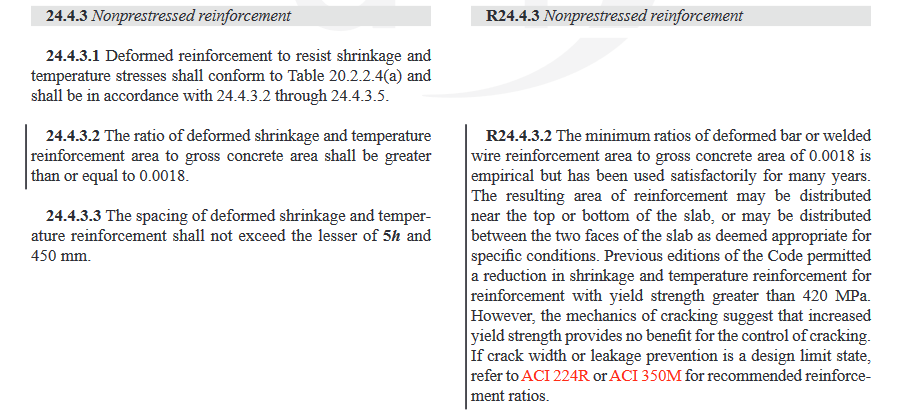

In [121]:
as = Mdemand/(fy*(d-a/2))
c = a/0.85
ϵs = 0.003*(d-c)/c 
if ϵs < 0.005
    println("NON ductile behavior")
end
# ϵs_calc = 0.85*fc′*a*b/Es

ρ_min = clamp(as/(section.area-as), 0.0018, Inf)

0.01789678839299022

In [122]:
#use Mdemand and Vdemand to find the right reinforcement steel ratio (ρ_s)
#area of steel is ρ_s*section_area(make sure you substract area of steel out too)


#ρ is capped (ρ_max) by the ductility of the section (ϵₛ> 0.005)
#set ϵs = 0.005
#we can find c
ϵs_max = 0.005
c_max = 3/8*d
a_max = 0.85*c_max
as = Mdemand/(fy*(d-a_max/2))
ρ_max = as/(section.area-as)

0.01798865097131507

In [123]:
ρ_selected = (ρ_min+ρ_max)/2

reinforcement_area = section_area*ρ_selected
a = reinforcement_area*fy/(0.85*fc′*b)
c = a/0.85
ϵs = 0.003*(d-c)/c
if ϵs < 0.005
    println("Please revise section")
end


# After we have the section, we have to check the serviceability L/240

In [124]:
# δ_max = 5*w*L^4/(384*E*I)

#find E and I of the beam. 
#we turn everything into a pure concrete with E = 4700sqrt(fc′) 
as_transformed = Es/Ec*as 
total_area = section.area-as+as_transformed
#find a new neutral axis of the section 
NA_concrete = section.centroid[2]
NA_rebar = -d
NA_section = (section.area*NA_concrete+as_transformed*NA_rebar)/total_area
print(NA_section)
@assert -d < NA_section < NA_concrete

I_RCsection = section.Ix + section.area*(NA_section-NA_concrete)^2 + as_transformed*(NA_rebar-NA_section)^2

@assert section.Ix < I_RCsection
# I_transformed_section = 



-344.24437565043826

In [125]:
δ_max = 5*w*span^4/(384*Ec*I_RCsection)

37.58302752624527

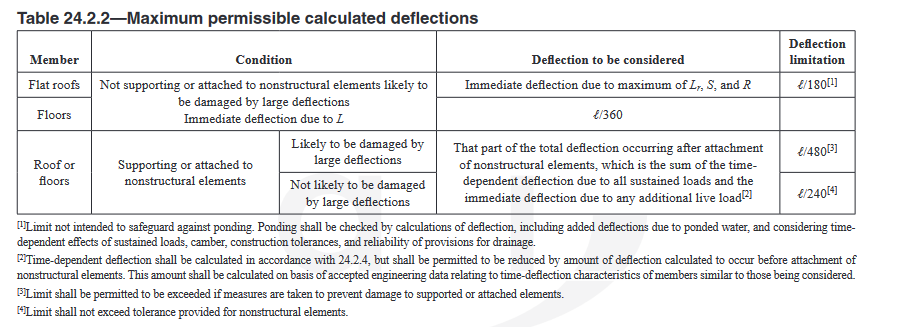

In [126]:
#Deflection limit L/240 
δ_limit =  span/240

@assert δ_max <= δ_limit
serviceability = false
if δ_max <= δ_limit
    serviceability = true
end


true

In [138]:
#Flexural design is done. 
@printf "Concrete section %d x %d sqmm\n" section.xmax-section.xmin section.ymax-section.ymin
@printf "Reinforcement area: %.2f sqmm\n" reinforcement_area
println("Serviceability: ", serviceability ? "Pass!" : "Fail")


Concrete section 300 x 600 sqmm
Reinforcement area: 3229.69 sqmm
Serviceability: Pass!


# Shear design

Add the minimum, which depends on the cross section size